

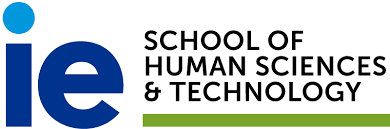
# Machine Learning Assignment by Omar Alieh

## Predicting whether a mammogram mass is benign or malignant

The data we will use for this assignment is entitled "mammographic masses" which is a public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:


   1. BI-RADS assessment: 1 to 5 (ordinal)  
   2. Age: patient's age in years (integer)
   3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
   4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
   5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
   6. Severity: benign=0 or malignant=1 (binominal)
   
BI-RADS is an assesment of how confident the severity classification is; it is not a "predictive" attribute and so we decided to discard it. The age, shape, margin, and density attributes are the features that we will build our model with, and "severity" is the classification we will attempt to predict based on those attributes.

In addition, "shape" and "margin" are nominal data types which we decided not to discard since they are close enough to ordinal data types.

False positives are the main reason why we're doing this supervised machine learning. Many suffer from unnecessary surgeries due to these mammogram results therefore it would helpful to improve a lot of lives.

Throughout this assignment we will apply several machine learning techniques to this dataset to see which one yields the highest accuracy as measure with K-Fold cross-validation. The techniques we will apply are the following:

* Decision tree
* Random forest
* KNN
* Naive Bayes
* SVM
* Logistic Regression

We performed some data cleaning at the beginning since many rows contain missing data and there might be some outliers as well that we need to handle.

## Preparing data

Importing the mammographic_masses.data.txt file into a Pandas dataframe using read_csv

In [1]:
import pandas as pd

data = pd.read_csv('mammographic_masses.data.txt')
data.head()

,5,67,3,5.1,3.1,1
0,4,43,1,1,?,1
1,5,58,4,5,3,1
2,4,28,1,1,3,0
3,5,74,1,5,?,1
4,4,65,1,?,3,0


Converting missing data (indicated by a ?) into NaN and adding the appropriate column names (BI_RADS, age, shape, margin, density, and severity):

In [2]:
data = pd.read_csv('mammographic_masses.data.txt', na_values=['?'], names = ['BI-RADS', 'age', 'shape', 'margin', 'density', 'severity'])
data.head()

,BI-RADS,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


Using .describe() on the dataframe to define whether the data needs cleaning 

In [3]:
data.describe()

,BI-RADS,age,shape,margin,density,severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


We notice that there a quite a few missing values in the data set. Instead of just eliminating rows that contain missing data we will try to see if we have a correlation in the data that has missing fields. In case of correlation, we will later try to fill the data.

In [4]:
data.loc[(data['age'].isnull()) |
              (data['shape'].isnull()) |
              (data['margin'].isnull()) |
              (data['density'].isnull())]

,BI-RADS,age,shape,margin,density,severity
1,4.0,43.0,1.0,1.0,NaN,1
4,5.0,74.0,1.0,5.0,NaN,1
5,4.0,65.0,1.0,NaN,3.0,0
6,4.0,70.0,NaN,NaN,3.0,0
7,5.0,42.0,1.0,NaN,3.0,0
...,...,...,...,...,...,...
778,4.0,60.0,NaN,4.0,3.0,0
819,4.0,35.0,3.0,NaN,2.0,0
824,6.0,40.0,NaN,3.0,4.0,1
884,5.0,NaN,4.0,4.0,3.0,1


Dropping the missing data that is randomly distributed using dropna().

In [5]:
data.dropna(inplace=True)
data.describe()

,BI-RADS,age,shape,margin,density,severity
count,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,4.393976,55.781928,2.781928,2.813253,2.915663,0.485542
std,1.888371,14.671782,1.242361,1.567175,0.350936,0.500092
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,46.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


Converting pandas dataframes to numpy arrays for them to be used with scikit_learn. We only want to work with shape, age , density and margin so we will create an extract only these features. We will also need two other arrays: one for the feature name labels and the other one that contains the classes (severity).

In [6]:
all_features = data[['age', 'shape',
                             'margin', 'density']].values


all_classes = data['severity'].values

feature_names = ['age', 'shape', 'margin', 'density']

all_features

array([[67.,  3.,  5.,  3.],
       [58.,  4.,  5.,  3.],
       [28.,  1.,  1.,  3.],
       ...,
       [64.,  4.,  5.,  3.],
       [66.,  4.,  5.,  3.],
       [62.,  3.,  3.,  3.]])

Normalizing the attribute data using preprocessing.StandardScaler() because some of our models will need the input data to be normalized.

In [7]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
all_features_scaled = scaler.fit_transform(all_features)
all_features_scaled

array([[ 0.7650629 ,  0.17563638,  1.39618483,  0.24046607],
       [ 0.15127063,  0.98104077,  1.39618483,  0.24046607],
       [-1.89470363, -1.43517241, -1.157718  ,  0.24046607],
       ...,
       [ 0.56046548,  0.98104077,  1.39618483,  0.24046607],
       [ 0.69686376,  0.98104077,  1.39618483,  0.24046607],
       [ 0.42406719,  0.17563638,  0.11923341,  0.24046607]])

## Decision Trees

Before moving to K-Fold cross validation and random forests, we start by creating a single train/test split of our data taking under consideration 75% for training and 25% for testing

In [8]:
import numpy
from sklearn.model_selection import train_test_split

numpy.random.seed(1234)

(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_features_scaled, all_classes, train_size=0.75, random_state=1)

Creating a DecisionTreeClassifier and fitting it to our training dataset.

In [9]:
from sklearn.tree import DecisionTreeClassifier

clf= DecisionTreeClassifier(random_state=1)

# Training the classifier on the training set
clf.fit(training_inputs, training_classes)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

We measure the accuracy of the resulting decision tree model using the test data.

In [10]:
clf.score(testing_inputs, testing_classes)

0.7355769230769231

### From here onwards, we will be using using K-Fold cross validation instead of a single train/test split to evaluate which model has better scores with K = 10. The metrics that we will evaluate are accuracy, precision, recall, f1 and auc_roc. 

#### The main focus will be mostly on precision, recall, f1 (average between precision and recall) and auc_roc

Throughout the rest of the models we will aim to achieve high precision and recall scores as we will be sure that this model will provide many results, with all results labeled correctly. The f1_score is the average between recall and precision so it would be also interesting to study this score closely. The auc_roc will give us an idea about the quality of the classifier (good classifiers are usually denoted above 50%).

##### We created a for loop which will iterate over the scores so that we can obtain all the scores we need.

The cross validation function is integrated within the for loop.

In [23]:
from sklearn.model_selection import cross_val_score

clf = DecisionTreeClassifier(random_state=1)

#cv_scores = cross_val_score(clf, all_features_scaled, all_classes, cv=10)
#cv_scores.mean()

for score in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
    print (score + ": "), print (cross_val_score(clf, all_features_scaled, all_classes, scoring=score, cv=10).mean())


accuracy: 
0.7373123154639465
precision: 
0.7450592334073678
recall: 
0.7115853658536586
f1: 
0.7242063355744223
roc_auc: 
0.7584620539934636


Trying RandomForestClassifier:

In [22]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10, random_state=1)
#cv_scores = cross_val_score(clf, all_features_scaled, all_classes, cv=10)
#cv_scores.mean()

for score in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
    print (score + ": "), print (cross_val_score(clf, all_features_scaled, all_classes, scoring=score, cv=10).mean())


accuracy: 
0.7528157927878762
precision: 
0.7456010179805616
recall: 
0.7563414634146342
f1: 
0.7478452957110949
roc_auc: 
0.8121972996515678


Using RandomForestClassifier gives us slightly better scores than DecisionTreesClassifier but these results still don't fulfill our expectations.

## KNN
Let's give it a shot using KNN with neighbors.KNeighborsClassifier which is a simplified version of implementing KNN from scratch. K is an example of hyperparameter and we will consider K to be equal to 10.

In [29]:
from sklearn import neighbors

clf = neighbors.KNeighborsClassifier(n_neighbors=10)
#cv_scores = cross_val_score(clf, all_features_scaled, all_classes, cv=10)
#cv_scores.mean()

for score in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
    print (score + ": "), print (cross_val_score(clf, all_features_scaled, all_classes, scoring=score, cv=10).mean())

accuracy: 
0.7854795488574507
precision: 
0.778941098291637
recall: 
0.786280487804878
f1: 
0.780771655690005
roc_auc: 
0.8373982220511573


It is not always easy to choose K therefore we created a for loop that runs KNN with K ranging from 1 to 100 to try and track the difference. We decided to include accuracy only for the sake of simplicity.

In [27]:
for n in range(1, 100):
    clf = neighbors.KNeighborsClassifier(n_neighbors=n)
    cv_scores = cross_val_score(clf, all_features_scaled, all_classes, cv=10)
    print (n, cv_scores.mean())

1 0.7239123742356184
2 0.6889838098036746
3 0.7541080699103032
4 0.7300813008130081
5 0.7735464506108056
6 0.7626163189342738
7 0.7940595133145824
8 0.7747082406280172
9 0.7880200243482641
10 0.7854795488574507
11 0.7915333809104012
12 0.7794257168045002
13 0.7819084701174035
14 0.7915039950743742
15 0.7878748443250353
16 0.7794411093852764
17 0.7818073688482151
18 0.775681121699341
19 0.7805147418944068
20 0.7828666582707136
21 0.7853927906748946
22 0.7817342540895289
23 0.7805588206484475
24 0.780587506821712
25 0.7878171221471251
26 0.7866269957880302
27 0.7854365195975539
28 0.7902271105327232
29 0.7865979597833844
30 0.7878314652337574
31 0.7914172368918182
32 0.7878314652337574
33 0.7865976099520032
34 0.7866119530386354
35 0.7866262961252677
36 0.7854358199347914
37 0.7866843681345592
38 0.7866553321299133
39 0.7878891874116676
40 0.7854791990260694
41 0.7854645061080558
42 0.7818500482767305
43 0.7830692106404713
44 0.783054867553839
45 0.783054867553839
46 0.7854648559394373
4

We notice that when K increased, we start getting an improved score. An optimal option for K could be K=90

## Naive Bayes

On to Naive Bayes method where we will also revise its scores using naive_bayes.MultinomialNB

In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

scaler = preprocessing.MinMaxScaler()
all_features_minmax = scaler.fit_transform(all_features)

#scoring = ['precision', 'recall', 'f1', 'accuracy']
clf = MultinomialNB()

for score in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
    print (score + ": "), print (cross_val_score(clf, all_features_minmax, all_classes, scoring=score, cv=10).mean())


accuracy: 
0.7844055665169388
precision: 
0.7524738745247708
recall: 
0.8460975609756097
f1: 
0.7940500781591437
roc_auc: 
0.8108022715609217


Despite having good accuracy and f1 scores, We notice that there's a some difference between recall and precision but we could aim to attain better scores with other models.

## SVM

Using svm.SVC with a linear kernel

In [21]:
from sklearn import svm

C = 1.0
svc = svm.SVC(kernel='linear', C=C)
#cv_scores = cross_val_score(svc, all_features_scaled, all_classes, cv=10)
#cv_scores.mean()

for score in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
    print (score + ": "), print (cross_val_score(svc, all_features_scaled, all_classes, scoring=score, cv=10).mean())


accuracy: 
0.7964988875362076
precision: 
0.7620836577211958
recall: 
0.8535365853658536
f1: 
0.8036497267485225
roc_auc: 
0.8669147556924075


With respect to the above techniques, svm.SVC resulted in improved scores but also close to the scores we got using Naive Bayes.

## SVM with different kernels

svm.SVC performs differently with different kernels so we will try rbf, sigmoid and poly kernels and detect the best performing kernel

### Rbf

In [17]:
C = 1.0
svc = svm.SVC(kernel='rbf', C=C, gamma='auto')
#cv_scores = cross_val_score(svc, all_features_scaled, all_classes, cv=10)
#cv_scores.mean()

for score in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
    print (score + ": "), print (cross_val_score(svc, all_features_scaled, all_classes, scoring=score, cv=10).mean())


accuracy: 
0.8012023704574396
precision: 
0.7669497731535856
recall: 
0.8582926829268294
f1: 
0.8076630763940471
roc_auc: 
0.8598978337790024


### Sigmoid

In [18]:
C = 1.0
svc = svm.SVC(kernel='sigmoid', C=C, gamma='auto')
#cv_scores = cross_val_score(svc, all_features_scaled, all_classes, cv=10)
#cv_scores.mean()

for score in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
    print (score + ": "), print (cross_val_score(svc, all_features_scaled, all_classes, scoring=score, cv=10).mean())


accuracy: 
0.7351055791108685
precision: 
0.7290813303596411
recall: 
0.731890243902439
f1: 
0.7269952483686668
roc_auc: 
0.7683032844448046


### Poly

In [19]:
C = 1.0
svc = svm.SVC(kernel='poly', C=C, gamma='auto')
#cv_scores = cross_val_score(svc, all_features_scaled, all_classes, cv=10)
#cv_scores.mean()

for score in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
    print (score + ": "), print (cross_val_score(svc, all_features_scaled, all_classes, scoring=score, cv=10).mean())


accuracy: 
0.792753942599667
precision: 
0.7520714117845052
recall: 
0.8707317073170732
f1: 
0.804242827114231
roc_auc: 
0.8602597371903951


Optimal option between the three is rbf who has an accuracy of almost 80% and the best f1 score

## Logistic Regression

After trying all these fancy techniques, we need to be aware that this is just a binary classification problem. Therefore we try Logistic Regression.

In [24]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs', multi_class='auto')
#cv_scores = cross_val_score(clf, all_features_scaled, all_classes, cv=10)
#cv_scores.mean()


for score in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
    print (score + ": "), print (cross_val_score(clf, all_features_scaled, all_classes, scoring=score, cv=10).mean())

accuracy: 
0.8073583532737221
precision: 
0.7816001266846073
recall: 
0.8484146341463414
f1: 
0.8113614381215865
roc_auc: 
0.87181812656997


The scores that we evaluated for Logistic Regression were surely fascinating. The precision and recall scores are approximately 78% and 84% respectively. That indicates that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results. F1 (average between precision and recall) has a score of almost 81% which means that precision and recall are pretty much in harmony. The roc_auc is also pretty high with a score of 87%

## Winners and losers

The models that performed the best were SVM-rbf kernel and Logistic Regression.

Therefore the most optimal technique could be Logistic Regression since we were able to achieve the goal we set at the beginning of the process which is having a high number of results that are accurate. 

The clear loser here is surely DecisionTrees which  had most of its scores around 75% only which were lower with respect to the other techniques who could be tuned to produce results at around 79-80% accuracy with precision around that range as well while having f1 scores between 70%-80%. Most models also had a better roc_auc score than DecisionTrees.

As a conclusion, we can say that additional hyperparameter tuning, or different topologies of the multi-level perceptron might also make a difference.